In [1]:
from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, find_offset, AnnealOffset

from qlp.tdse import (
    s_to_offset,
    AnnealSchedule,
    TDSE,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

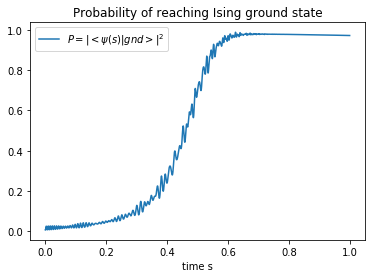

In [29]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = -0.01*np.arange(11)
for offset_min in [-0.01]: #offset_min_list:
    
    graph, tag = gt.generate_nn_graph(3)
    penalty = 2

    annealing_time = 1  # microseconds

    offset = "negbinary"
    offset_min = offset_min
    offset_range = -2*offset_min

    solver_params = dict()
    solver_params["method"] = "RK45"
    solver_params["rtol"] = 1e-6
    solver_params["atol"] = 1e-7

    tdse_solve = True

    """Start Program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    #print("QUBO")
    #print(qubo.todense())

    # number of qubits
    n = len(qubo.todense())

    # convert to Ising
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())

    #######################################################################################
    # this is the unit conversion of energy/time (since we set time interval to be [0,1])
    #######################################################################################

    # assume annealing_time unit in microsecond and energy unit in Ghz
    def energyscaleconversion(annealing_time):
        return annealing_time * 1000.0


    energyscale = energyscaleconversion(annealing_time)

    ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}
    offset_params = {"offset": offset, "offset_min": offset_min, "offset_range": offset_range}

    #print("Ising")
    #print(Jij)
    #print(hi)
    #print(energyscale)

    # plot graph
    #gt.get_plot(graph, directed=directed)
    #plt.show()
    # initial state
    xev=np.asarray([1.0/np.sqrt(2.0),1.0/np.sqrt(2.0)])
    y0=xev[:]
    for i in range(n-1):
        y0=np.kron(xev,y0)
    y0=(1.0+0.0j)*y0 #ensure complex dtype
    #print('initial state',y0)

    # solve ode
    tdse = TDSE(n, ising_params, offset_params)
    if tdse_solve:
        sol=solve_ivp(tdse, [0.0, 1.0], y0, **solver_params)

        #print('ode solution')
        #for i in range(sol.t.size):
        #    print('time',i,'=',sol.t[i])
        #    print(sol.y[:,i])


        # brute force diagonalization Ising hamiltonain

        energy,eigv=np.linalg.eigh(tdse.IsingH)
        #print('brute force Ising')
        #print('eigen envergy',energy)
        #print('eigen vector')
        #print(eigv)

        # plot probability overlap with Ising ground state
        overlap=np.zeros(sol.t.size)
        for i in range(sol.t.size):
            overlap[i]=np.absolute(np.dot(eigv[:,0],sol.y[:,i]))**2


        plt.plot(sol.t,overlap)
        plt.legend([r'$P= |<\psi (s) | gnd >|^2$'])
        plt.xlabel('time s')
        plt.title('Probability of reaching Ising ground state')
        plt.show()
    result[offset_min] = tdse
    with open(f"../qlp/mds/tdse/{offset}_{offset_min}.pickle", "wb") as file:
        rpickle = dict()
        rpickle["tdse"] = tdse
        rpickle["sol"] = sol
        rpickle["overlap"] = overlap
        pickle.dump(result, file)

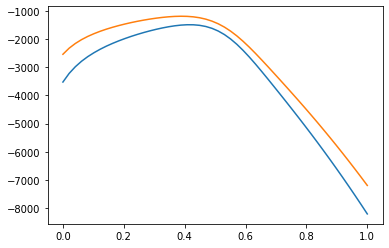

In [3]:
fig = plt.figure()
ax = plt.axes()
gap = dict()
for key in result.keys():
    x = []
    y0 = []
    y1 = []
    for s in np.linspace(0, 1):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = np.sort(eigval)
        x.append(s)
        y0.append(seigval[0])
        y1.append(seigval[1])
    ax.errorbar(x=x, y=y0)
    ax.errorbar(x=x, y=y1)
    gap[key] = np.array(y1) - np.array(y0)
plt.draw()
plt.show()

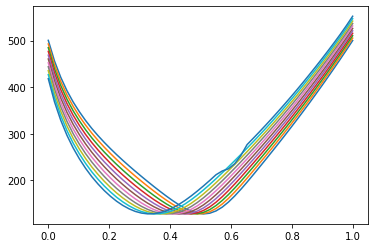

In [73]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    ax.errorbar(x=x, y=gap[key], label=key)
#ax.legend()
plt.draw()
plt.show()

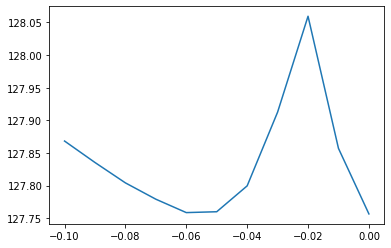

In [74]:
mingap = {key: min(gap[key]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y=list(mingap.values())
ax.errorbar(x=x,y=y)
plt.draw()
plt.show()

In [25]:
with open("./test.pickle", "rb") as file:
    r = pickle.load(file)

{'Jij': array([[ 0.,  2.,  1., -1., -1., -2.,  0.],
        [ 0.,  0.,  2., -1., -1., -2., -1.],
        [ 0.,  0.,  0.,  0., -1., -2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 'hi': array([-2.5, -3.5, -2.5,  1. ,  2. ,  4. ,  1. ]),
 'c': 5.5,
 'energyscale': 1000.0}